In [35]:
import tensorflow as tf
import numpy as np
import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
PATH = "/content/drive/My Drive/Datasets/Segmentation/CamVid/"

TRAIN_IMG_PATH = PATH + "train"
TRAIN_MSK_PATH = PATH + "train_mask"
TEST_IMG_PATH = PATH + "test"
TEST_MSK_PATH = PATH + "test_mask"
VAL_IMG_PATH = PATH + "val"
VAL_MSK_PATH = PATH + "val_mask"

train_imgs = os.listdir(TRAIN_IMG_PATH)
mask_imgs = os.listdir(TRAIN_MSK_PATH)

test_imgs = os.listdir(TEST_IMG_PATH)
val_imgs = os.listdir(VAL_IMG_PATH)

print(len(train_imgs), len(test_imgs), len(val_imgs))

600 50 50


In [38]:
SHUFFLE_SIZE = 600
BATCH_SIZE = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
EPOCHS = 300

In [39]:
def resize(train_img, masked_img, height, width):
    train_img = tf.image.resize(train_img, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    masked_img = tf.image.resize(masked_img, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return train_img, masked_img

In [40]:
def random_crop(train_img, masked_img):
    stacked_image = tf.stack([train_img, masked_img], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [41]:
# normalizing the images to [-1, 1]

def normalize(train_img, masked_img):
    train_img = (train_img / 127.5) - 1
    masked_img = (masked_img / 127.5) - 1

    return train_img, masked_img

In [42]:
@tf.function()
def randomizer(train_img, masked_img):
    # resizing to 286 x 286 x 3
    train_img, masked_img = resize(train_img, masked_img, 286, 286)

    # randomly cropping to 256 x 256 x 3
    train_img, masked_img = random_crop(train_img, masked_img)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        train_img = tf.image.flip_left_right(train_img)
        masked_img = tf.image.flip_left_right(masked_img)

    return train_img, masked_img

In [43]:
# Image Loading
def load_train_image(filename, augment=True):
  
    train_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TRAIN_IMG_PATH + '/' + filename)), tf.float32)
    masked_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TRAIN_MSK_PATH + '/' + filename)), tf.float32)

    train_img, masked_img = resize(train_img, masked_img, IMG_HEIGHT, IMG_WIDTH)
    
    if augment:
        train_img, masked_img = randomizer(train_img, masked_img)
      
    train_img, masked_img = normalize(train_img, masked_img)
    
    return train_img, masked_img

def load_val_image(filename, augment=True):
  
    validation_imgs = tf.cast(tf.image.decode_jpeg(tf.io.read_file(VAL_IMG_PATH + '/' + filename)), tf.float32)
    validation_msks = tf.cast(tf.image.decode_jpeg(tf.io.read_file(VAL_MSK_PATH + '/' + filename)), tf.float32)

    validation_imgs, validation_msks = resize(validation_imgs, validation_msks, IMG_HEIGHT, IMG_WIDTH)
      
    validation_imgs, validation_msks = normalize(validation_imgs, validation_msks)
    
    return validation_imgs, validation_msks

def load_test_image(filename):
  
    test_imgs = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TEST_IMG_PATH + '/' + filename)), tf.float32)
    test_msks = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TEST_MSK_PATH + '/' + filename)), tf.float32)

    test_imgs, test_msks = resize(test_imgs, test_msks, IMG_HEIGHT, IMG_WIDTH)
      
    test_imgs, test_msks = normalize(test_imgs, test_msks)
    
    return test_imgs, test_msks

def load_train_img(filename):
    return load_train_image(filename, True)

def load_validation_img(filename):
    return load_val_image(filename)

def load_test_img(filename):
    return load_test_image(filename)

In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs)
train_dataset = train_dataset.map(load_train_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(SHUFFLE_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [45]:
val_dataset = tf.data.Dataset.from_tensor_slices(val_imgs)
val_dataset = val_dataset.map(load_val_image)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [46]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_imgs)
test_dataset = test_dataset.map(load_test_img)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [47]:
def downsample(filters, apply_batchnorm = True):
  
  result = tf.keras.Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  # Capa convolucional.
  result.add(tf.keras.layers.Conv2D(filters,
                                    kernel_initializer = initializer,
                                    kernel_size = 4,
                                    strides = 2,
                                    padding = "same",
                                    use_bias = not apply_batchnorm))
  
  if apply_batchnorm:
    # Capa batchNorm
    result.add(tf.keras.layers.BatchNormalization())
  
  # Capa de activación.
  result.add(tf.keras.layers.LeakyReLU())
  
  return result

In [48]:
def upsample(filters, apply_dropout = False):
  
    result = tf.keras.Sequential()
    
    initializer = tf.random_normal_initializer(0, 0.02)
    # Capa convolucional.
    result.add(tf.keras.layers.Conv2DTranspose(filters,
                                               kernel_initializer = initializer,
                                               kernel_size = 4,
                                               strides = 2,
                                               padding = "same",
                                               use_bias = False))
    

    # Capa batchNorm
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
      # Capa de Dropout
      result.add(tf.keras.layers.Dropout(0.5))
      
    # Capa de activación.
    result.add(tf.keras.layers.ReLU())
    
    return result

In [49]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape = [None, None, 3])
  
  down_stack = [
      downsample(64, apply_batchnorm = False), # (bs, 512, 256, 64 )
      downsample(128),                        # (bs, 256, 128, 128 )
      downsample(256),                        # (bs, 128, 64, 256 )
      downsample(512),                        # (bs, 64, 32, 512 )
      downsample(512),                        # (bs, 32, 16, 512 )
      downsample(512),                        # (bs, 16, 8, 512 )
      downsample(512),                        # (bs, 8, 4, 512 )
      downsample(512),                        # (bs, 4, 2, 512 )
  ]
  
  up_stack = [
      upsample(512, apply_dropout = True),    # (bs, 8, 4, 1024 )
      upsample(512, apply_dropout = True),    # (bs, 16, 8, 1024 )
      upsample(512, apply_dropout = True),    # (bs, 32, 16, 1024 )
      upsample(512),                          # (bs, 64, 32, 1024 )
      upsample(256),                          # (bs, 128, 64, 512 )
      upsample(128),                          # (bs, 256, 128, 256 )
      upsample(64),                           # (bs, 512, 256, 128 )
  ]
  
  initializer = tf.random_normal_initializer(0, 0.02)

  last = tf.keras.layers.Conv2DTranspose(filters= 3,
                                        kernel_size = 4,
                                        strides = 2,
                                        padding = "same",
                                        kernel_initializer = initializer,
                                        activation = "tanh")
  
  x = inputs
  s = []
  
  for down in down_stack:
    x = down(x)
    s.append(x)
    
  s = reversed(s[:-1])
  
  for up, sk in zip(up_stack, s):
    
    x = up(x)
    x = tf.concat([x, sk], axis=3)
    
  last = last(x)
  
  return tf.keras.Model(inputs = inputs, outputs = last)

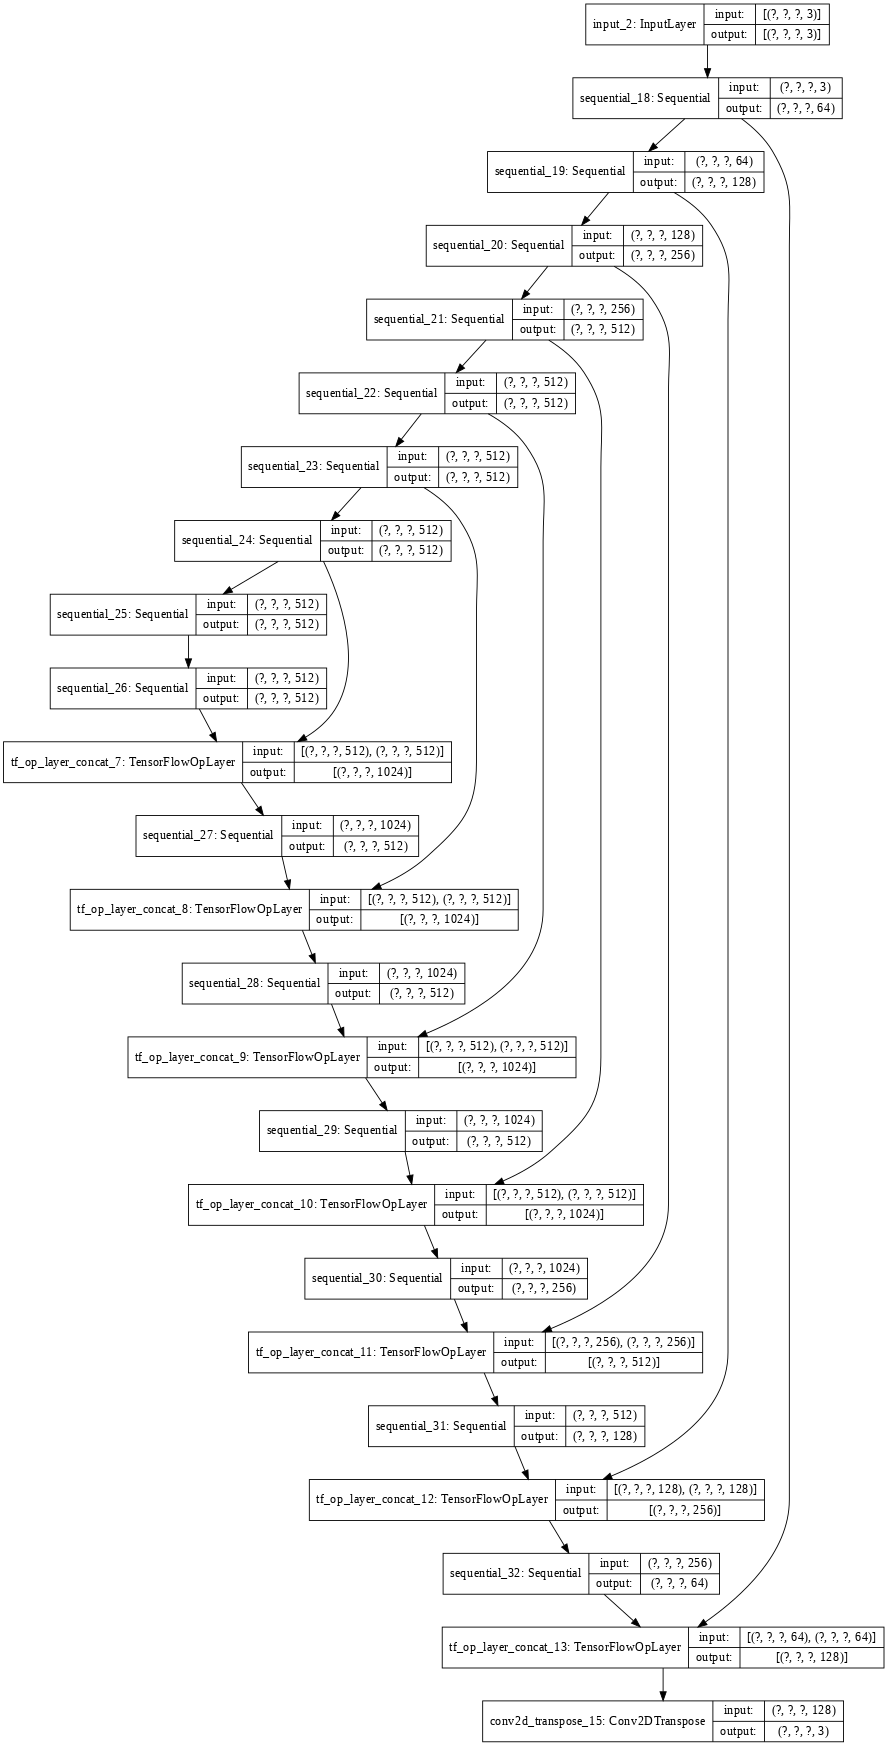

In [50]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [51]:
LAMBDA = 100  #100 times more importance to the L1 loss than the adversarial loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [52]:
def downsampleD(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
      result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [53]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsampleD(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsampleD(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsampleD(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer,
                                  activation='sigmoid')(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

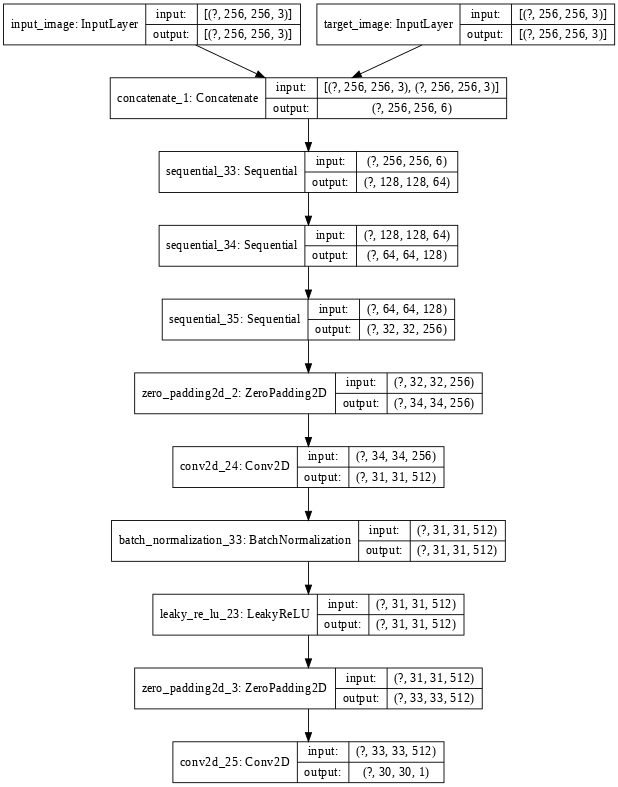

In [54]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [55]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [56]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [57]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [58]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

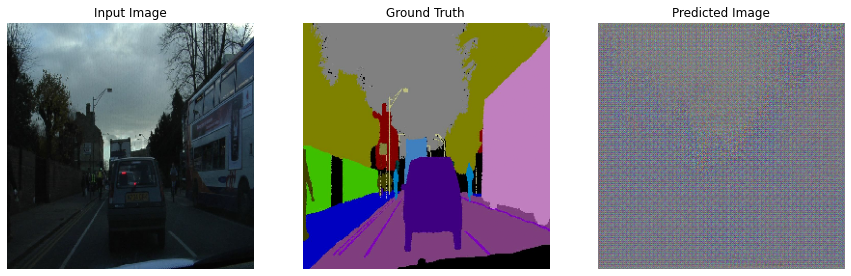

In [59]:
for example_input, example_target in val_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [60]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))


In [61]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5

    y_true = y_true * 0.5 + 0.5
    y_pred = y_pred * 0.5 + 0.5

    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [62]:
x_axis = []
y_axis = []

def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
        generate_images(generator, example_input, example_target)
        prediction = generator(example_input, training=True)
        dice_loss = dice_coef(tf.squeeze(example_target[0]), tf.squeeze(prediction[0]))
    x_axis.append(epoch)
    y_axis.append(dice_loss)
    print("Epoch: {}   Dice Coeficient: {}".format(epoch, dice_loss))

    if dice_loss > 0.9:
        break

    for n, (input_image, target) in train_ds.enumerate():
      print('|', end='')

      train_step(input_image, target, epoch)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

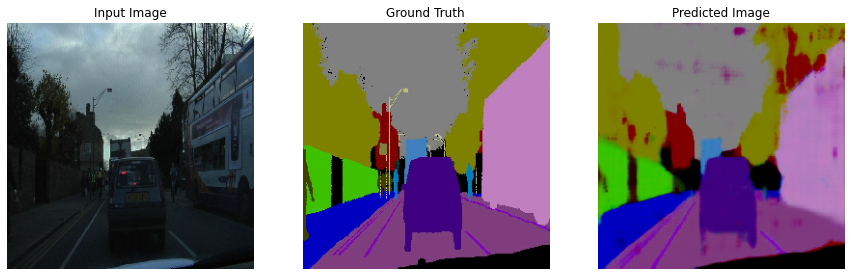

Epoch: 299   Dice Coeficient: 0.8128503561019897
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Time taken for epoch 300 is 14.170639753341675 sec



In [63]:
fit(train_dataset, EPOCHS, val_dataset)

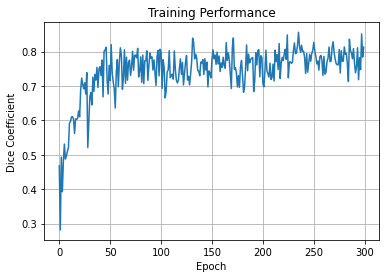

In [64]:
fig, ax = plt.subplots()
ax.plot(x_axis, y_axis)

ax.set(xlabel='Epoch', ylabel='Dice Coefficient',
       title='Training Performance')
ax.grid()
#fig.savefig("test.png")
plt.show()

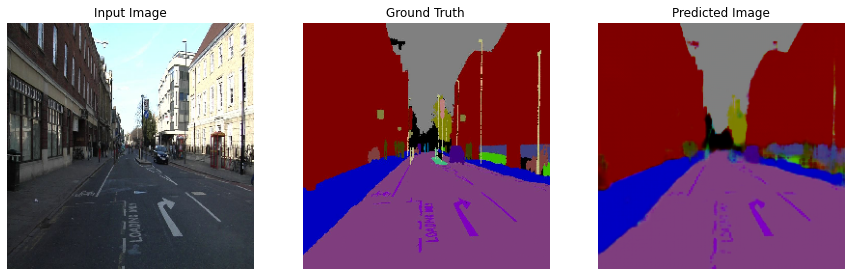

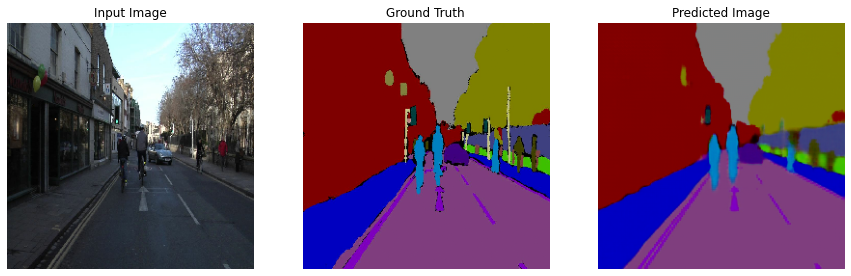

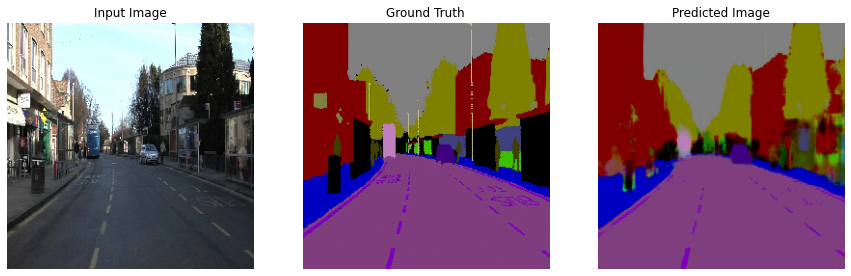

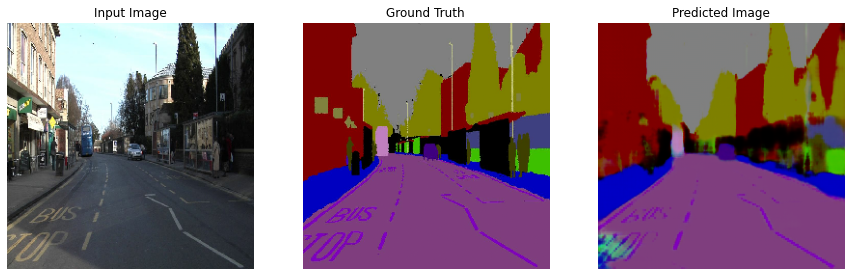

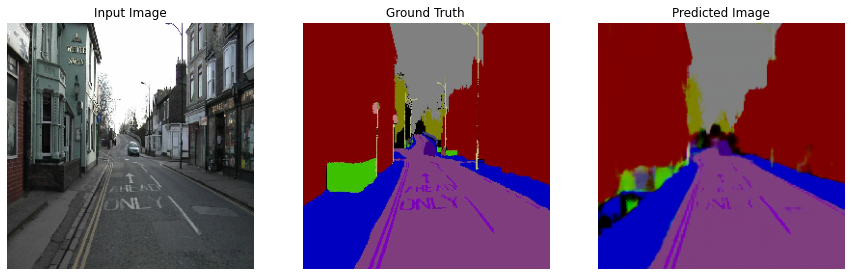

In [65]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(10):
  generate_images(generator, inp, tar)

In [66]:
generator.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, None, None, 6 3136        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_19 (Sequential)      (None, None, None, 1 131584      sequential_18[0][0]              
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, None, None, 2 525312      sequential_19[0][0]              
_______________________________________________________________________________________

In [67]:
discriminator.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_33 (Sequential)      (None, 128, 128, 64) 6144        concatenate_1[0][0]   

In [68]:
np.array(x_axis).shape

(300,)